## Continuous Sapientino.

Level of abstraction "two", with restraining bolts.

The goal is to visit N colors in a certain order.

We use a modular network architecture: that is, for each state of
the goal automaton, we activate the $q^{th}$ subnetwork.

In [1]:
import tempfile
import time
from pathlib import Path

import gym
import numpy as np
from flloat.semantics import PLInterpretation
from gym.wrappers import TimeLimit
from stable_baselines import DQN

from gym_sapientino import SapientinoDictSpace
from gym_sapientino.core.configurations import (
    SapientinoAgentConfiguration,
    SapientinoConfiguration,
)
from multinav.algorithms.modular_dqn import ModularPolicy
from multinav.envs.env_cont_sapientino import Fluents
from multinav.envs.env_grid_sapientino import generate_grid
from multinav.envs.temporal_goals import SapientinoGoal
from multinav.helpers.gym import rollout
from multinav.helpers.notebooks import plot_env, display_img_array, print_env
from multinav.restraining_bolts.rb_grid_sapientino import GridSapientinoRB
from multinav.wrappers.sapientino import ContinuousRobotFeatures
from multinav.wrappers.temprl import MyTemporalGoalWrapper
from multinav.wrappers.utils import MyStatsRecorder, SingleAgentWrapper

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

pygame 2.0.1 (SDL 2.0.14, Python 3.7.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%matplotlib inline
%load_ext tensorboard

Observation space: Box(-40.0, 360.0, (6,), float32)


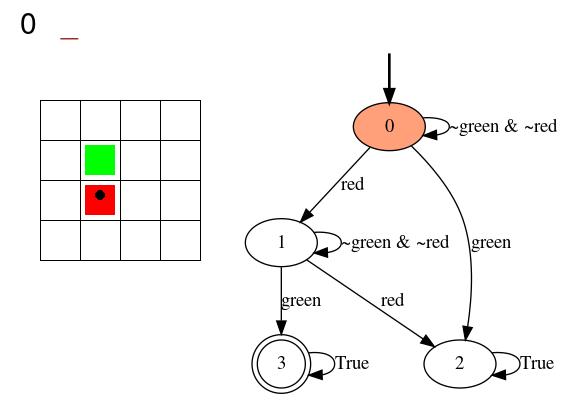

In [3]:
SQUARE_MAP = """\
    |
 g  |
 r  |
    |"""

COLORS = ["red", "green"]

agent_configuration = SapientinoAgentConfiguration(continuous=False, initial_position=(1, 2))
temp_file = Path(tempfile.mktemp(suffix=".txt"))
temp_file.write_text(SQUARE_MAP)
configuration = SapientinoConfiguration(
    (agent_configuration, ),
    path_to_map=temp_file,
    reward_per_step=-0.01,
    reward_outside_grid=-1.0,
    reward_duplicate_beep=0.0,
)
env = SingleAgentWrapper(SapientinoDictSpace(configuration))
tg = SapientinoGoal(
    colors=COLORS,
    fluents=Fluents(colors_set=set(COLORS)),
    reward=1.0,
)
env = ContinuousRobotFeatures(MyTemporalGoalWrapper(env, [tg]))

print(f"Observation space: {env.observation_space}")
display_img_array(env.render(mode="rgb_array"))

In [4]:
%tensorboard --logdir logs

In [ ]:
learn_env = MyStatsRecorder(TimeLimit(env, max_episode_steps=30))

model = DQN(ModularPolicy, learn_env, verbose=1, tensorboard_log="./logs",
            learning_starts=5000, exploration_final_eps=0.1, policy_kwargs=dict(layers=[64, 64]))
model.learn(total_timesteps=50000)







Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










--------------------------------------
| % time spent exploring  | 47       |
| episodes                | 100      |
| mean 100 episode reward | -14.7    |
| steps                   | 2893     |
--------------------------------------


--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 200      |
| mean 100 episode reward | -14.6    |
| steps                   | 5750     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 300      |
| mean 100 episode reward | -7.3     |
| steps                   | 8693     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 400     

In [ ]:
test_env = MyStatsRecorder(TimeLimit(env, max_episode_steps=10))
rollout(test_env, nb_episodes=1, policy=lambda env, state: model.predict(state)[0], callback=print_env)
test_env.close()


print("done!")
print(f"episode rewards: {test_env.episode_rewards}")
print(f"episode lengths: {test_env.episode_lengths}")
print('mean reward:', np.mean(test_env.episode_rewards))
